# HW3 

In [221]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os

In [222]:
np.random.seed(130226)
random.seed(130226)

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # <--- The magic library for aesthetics

# --- SOTA Math Aesthetic Configuration ---
# 'context="talk"' makes everything (lines, fonts, ticks) bigger and bolder automatically.
# 'style="ticks"' provides a clean look with ticks on axes (classic paper style).
sns.set_theme(context="talk", style="ticks", font="serif", font_scale=1.1)

# Specific overrides to ensure it uses Times New Roman/Serif and high-res saving
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm', # LaTeX-style math
    'axes.grid': True,        # Turn grid on
    'grid.alpha': 0.5,        # Light grid
    'grid.linestyle': '--',   # Dashed grid
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Professional Color Palette
COLORS = {
    'S': '#0072B2',  # Blue
    'I': '#D55E00',  # Vermilion (Red-Orange)
    'R': '#009E73',  # Bluish Green
    'V': '#56B4E9',  # Sky Blue
    'Target': 'black',
    'Grid': '#E0E0E0'
}

def sir_plot(s, i, r, v=[], file=None):
    # Figure size is slightly larger to accommodate the "Talk" context scaling
    fig, ax = plt.subplots(figsize=(10, 6)) 

    ticks = np.arange(0, s.shape[0], dtype=int)

    # Plot lines - Note: linewidth is now handled automatically by the context, 
    # but we add markeredgecolor for that crisp "SOTA" look.
    ax.plot(ticks, s, label="Susceptible ($S$)", color=COLORS['S'], markeredgecolor='white', markeredgewidth=1.5)
    ax.plot(ticks, i, label="Infected ($I$)", color=COLORS['I'], markeredgecolor='white', markeredgewidth=1.5)
    ax.plot(ticks, r, label="Recovered ($R$)", color=COLORS['R'], markeredgecolor='white', markeredgewidth=1.5)
    
    if len(v) > 0:
        ax.plot(ticks, v, label="Vaccinated ($V$)", color=COLORS['V'], markeredgecolor='white', markeredgewidth=1.5)

    ax.set_xticks(ticks)
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('Population Count')
    
    # Clean up spines using Seaborn's utility
    sns.despine(trim=True, offset=10) # Removes top and right spines, and detaches axes slightly

    ax.legend(loc='best')

    if file:
        plt.savefig(file, format='pdf')
        print(f"Figure saved to {file}")
    
    plt.show()

def ni_plot(ni, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color=COLORS['I'], label="New Infections", markeredgecolor='white', markeredgewidth=1.5)

    ax.set_xticks(ticks)
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('Newly Infected Nodes')
    
    sns.despine(trim=True, offset=10)

    if file:
        plt.savefig(file, format='pdf')
        print(f"Figure saved to {file}")

    plt.show()

def ninv_plot(ni, nv, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color=COLORS['I'], label="Newly Infected ($I_{new}$)", markeredgecolor='white', markeredgewidth=1.5)
    ax.plot(ticks, nv, color=COLORS['V'], label="Newly Vaccinated ($V_{new}$)", markeredgecolor='white', markeredgewidth=1.5)

    ax.set_xticks(ticks)
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('Number of Nodes')
    
    sns.despine(trim=True, offset=10)
    ax.legend()

    if file:
        plt.savefig(file, format='pdf')
        print(f"Figure saved to {file}")

    plt.show()

def ni_comparison_plot(ni, ni_target, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    # Simulation data
    ax.plot(ticks, ni, color=COLORS['I'], label="Simulation ($I_{sim}$)", markeredgecolor='white', markeredgewidth=1.5, zorder=3)
    
    # Real data
    ax.plot(ticks, ni_target, color=COLORS['Target'], label="Real Data ($I_{real}$)", 
            linestyle="--", alpha=0.8, zorder=2)

    ax.set_xticks(ticks)
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('Newly Infected Nodes')
    
    sns.despine(trim=True, offset=10)
    ax.legend()

    if file:
        plt.savefig(file, format='pdf')
        print(f"Figure saved to {file}")

    plt.show()

In [226]:
# Generate a symmetric k-regular graph with n nodes and k neighbors of each node
def generator_k_regular_graph(n, k):
    
    if (k > n) or (n <= 0) or (k <= 1):
        raise ValueError("Invalid parameters")

    nodes = list(range(n))
    edges = []

    if k % 2 != 0:
        k = k-1

    relative_neighbors = np.concatenate([np.arange(-k/2, 0), np.arange(1, k/2+1)])

    for node in nodes:
        for neighbor in relative_neighbors:
            # Add an edge between each node and the four nodes whose index is closest to the node's own index
            edges.append((node, nodes[(node + int(neighbor)) % n]))

    graph = nx.Graph()
    graph.add_nodes_from(nodes)  # Needed to keep nodes in ascending order
    graph.add_edges_from(edges)
#     nx.draw_circular(graph)

    return graph

# random graph according to the preferential attachment model
def generator_preferential_attachment(nodes, k_degree):
    
    if (k_degree > nodes) or (nodes <= 0) or (k_degree <= 1):
        raise ValueError("Invalid parameters")

    graph = nx.complete_graph(k_degree+1, nx.DiGraph()) # we start with a complete graph of k+1 nodes !!!!!!!!!!!!
        
    # since k may be odd or even, we split the connections, one floored and one ceiled so in the long run the number of new edges per new node is ≈ k/2
    cf = math.floor(k_degree/2)
    cc = math.ceil(k_degree/2)
    
    for node in range(k_degree+1, nodes): # generates integers node IDs that are not in the graph yet.
        
        # compute the in-degree distribution w_i
        in_deg = np.array([d for n, d in graph.in_degree()])
        in_deg_p = in_deg/sum(in_deg)
        
        # lets choose cf or cc nodes to connect to based on in-degree distribution
        if node%2 == 0:
            connect_nodes = np.random.choice(range(0,len(in_deg)),p=in_deg_p, size=cf, replace=False) 
        else:
            connect_nodes= np.random.choice(range(0,len(in_deg)),p=in_deg_p, size=cc, replace=False) 
        
        for cn in connect_nodes:
            graph.add_edge(cn, node)
            graph.add_edge(node, cn) 
            
    return graph

# Generate a graph according to the newman-watts-strogatz model.
def generator_newman_watts_strogatz(nodes, k_degree, prob = 0.5):
    
    if (k_degree > nodes) or (nodes <= 0) or (k_degree <= 1):
        raise ValueError("Invalid parameters")
        
    graph = nx.newman_watts_strogatz_graph(nodes, k_degree, prob)
    return graph

import networkx as nx

def generator_subset_facebook_graph(graph_path, target_n=934):
    # 1. Load the full dataset
    full_graph = nx.read_edgelist(graph_path, nodetype=int)
    
    # 2. To keep the graph realistic, we take the neighborhood of a high-degree node
    # This ensures our subset is dense and connected.
    # Start with a random "seed" node that has many connections
    nodes_by_degree = sorted(full_graph.degree, key=lambda x: x[1], reverse=True)
    seed_node = nodes_by_degree[0][0] # The "hub" node
    
    # 3. Use Breadth-First Search (BFS) to find the nearest 934 nodes
    subset_nodes = []
    bfs_edges = nx.bfs_edges(full_graph, source=seed_node)
    
    subset_nodes.append(seed_node)
    for u, v in bfs_edges:
        if len(subset_nodes) < target_n:
            subset_nodes.append(v)
        else:
            break
            
    # 4. Create the subgraph and relabel it
    sub_g = full_graph.subgraph(subset_nodes).copy()
    sub_g = nx.convert_node_labels_to_integers(sub_g, first_label=0)
    
    return sub_g

In [228]:
"""Simulate an epidemic in discrete-time SIR model or SIRV model with vaccinations.
   Possible states:
   S = 0
   I = 1
   R = 2
   V = 3

    Args:
        graph: the graph where the simulation take place
        beta: probability that the infection is spread from an infected individual to a susceptible one, 
            given that they are connected by a link, during one time step
        rho: probability that an infected individual will recover during one time step
        n_weeks: number of weeks through the simulation take place, number of steps of simulation
        n_infected_init: number of infected nodes in the initial configuration, 
            chosen randomly among all nodes of the graph according to a uniform probability distribution
        vacc: total fraction of population that has received vaccination by
            each week

    Returns:
        susceptibles                : vector containing the number of susceptible agents for each week
        infected, new_infected      : vectors containing the number of infected and new infected agents for each week
        recovered                   : vector containing the number of recovered agents for each week
        vaccinated, new_vaccinated  : vectors containing the number of vaccinated and new vaccinated agents for each week
    """

def simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vacc = None):
    
    W = nx.to_scipy_sparse_array(graph, format='csr')
    
    agents = np.zeros(N_nodes, dtype="int")
    appo_agents = np.zeros(N_nodes, dtype="int")
    
    # initial infected nodes - clustered focolare following realistic scenario of an pandemy outbreak----------------------------
    # we select a random patient zero and then some nodes around him/her
    patient_zero = np.random.randint(0, N_nodes)
    outbreak_size = 20 
    outbreak = [(patient_zero + i) % N_nodes for i in range(-int((outbreak_size/2)), int((outbreak_size/2)))]
    outbreak = np.random.choice(outbreak, size=n_infected_init, replace=False)
    agents = np.zeros(N_nodes) # Assuming 0=Susceptible, 1=Infected
    agents[outbreak] = 1
    #-----------------------------------------------------------------------------------------------------------------------------
    # define states vectors
    susceptibles = np.zeros(n_weeks, dtype="int")
    infected = np.zeros(n_weeks, dtype="int")
    recovered = np.zeros(n_weeks, dtype="int")
    new_infected = np.zeros(n_weeks, dtype="int")
    vaccinated = np.zeros(n_weeks, dtype="int")
    new_vaccinated = np.zeros(n_weeks, dtype="int")

    # define initial conditions
    susceptibles[0] = N_nodes - n_infected_init
    infected[0] = n_infected_init
    new_infected[0] = n_infected_init
    susceptibles[0] = len(np.where(agents[:] == 0)[0])
    infected[0] = len(np.where(agents[:] == 1)[0])
    recovered[0] = len(np.where(agents[:] == 2)[0])
    already_vaccinated_agents = 0

    # for every week
    for j in range(1, n_weeks):
        week_infected = 0

        # if SIRV model, we vaccinate some agents at the beginning of the week-------------------------------------------------
        # vacc[j-1] indicates the CURRENT WEEK percentage of vaccinatded
        # vaccinated[j-1] indicates the total amount of vaccinated nodes until LAST WEEK
        if vacc is not None:
            already_vaccinated_agents = vaccinated[j-1] 
            nodes_vacc = int((N_nodes*vacc[j-1]) / 100) # new amount of total vaccinated nodes at step at week j
            
            if nodes_vacc > already_vaccinated_agents: # if we need to vaccinate new nodes 
                candidates = np.where(agents[:] != 3)[0] # choose between [S, I, R] states only (an infected can be vaccinated)
                new_doses = nodes_vacc - already_vaccinated_agents
                vaccinated_agents = np.random.choice(candidates, 
                                                     size=new_doses, replace=False)
                
                for node in vaccinated_agents:
                    agents[node] = 3 # state VACCINATED
                    new_vaccinated[j] +=1        
        #-----------------------------------------------------------------------------------------------------------------------------            
        appo_agents = np.array(agents) # temporary copy of agents to update states simultaneously
        
        m_values = W @ (agents == 1)
        S_idx = np.where(agents == 0)[0]
        if len(S_idx) > 0:
            # Probability for each S node: 1 - (1-beta)^m 
            p_inf = 1 - (1 - beta)**m_values[S_idx]
            # roll dice for all S nodes at once
            infected_today = np.random.rand(len(S_idx)) < p_inf 
            
            newly_infected_nodes = S_idx[infected_today]
            new_infected[j] = len(newly_infected_nodes)

        I_idx = np.where(agents == 1)[0]
        if len(I_idx) > 0: # some infected nodes exist
            recovered_today = np.random.rand(len(I_idx)) < rho
            newly_recovered_nodes = I_idx[recovered_today]
        else:
            newly_recovered_nodes = []

        agents[newly_infected_nodes] = 1
        agents[newly_recovered_nodes] = 2

        susceptibles[j] = np.sum(agents == 0)
        infected[j] = np.sum(agents == 1)
        recovered[j] = np.sum(agents == 2)
        vaccinated[j] = np.sum(agents == 3)

    if vacc is not None:
        return susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated
    return susceptibles, infected, recovered, new_infected

In [229]:
def epidemic(n_simulations, 
             type_graph, 
             k_neighbors,
             n_nodes, 
             beta, 
             rho, 
             n_weeks, 
             n_infected_init, 
             vacc = None, # array with fraction of population vaccinated at each week
             prob = 0.5,):
    
    # create the graph  
    if type_graph == "k_regular":
        graph = generator_k_regular_graph(n_nodes, k_neighbors)
    elif type_graph == "preferential_attachment":
        graph = generator_preferential_attachment(n_nodes, k_neighbors)
    elif type_graph == "newman_watts_strogatz":
        graph = generator_newman_watts_strogatz(n_nodes, k_neighbors, prob)
    elif type_graph == 'facebook':
        graph = generator_subset_facebook_graph(graph_path)
    else:
        print("Invalid name")
        return None
    
    # Initialize arrays for computing averages over simulations
    S = np.zeros((n_simulations, n_weeks+1), dtype="int")
    I = np.zeros((n_simulations, n_weeks+1), dtype="int")
    R = np.zeros((n_simulations, n_weeks+1), dtype="int")
    NI = np.zeros((n_simulations, n_weeks+1), dtype="int")
    if vacc is not None:
        V = np.zeros((n_simulations, n_weeks+1), dtype="int")
        NV = np.zeros((n_simulations, n_weeks+1), dtype="int")
    
    for j in range(n_simulations):
        
        # SIRV model
        if vacc is not None:
            s, i, r, ni, v, nv  = simulation_SIR(graph = graph,
                                                 N_nodes = n_nodes, 
                                                 beta = beta, 
                                                 rho = rho, 
                                                 n_weeks = n_weeks+1, 
                                                 n_infected_init = n_infected_init,
                                                 vacc = vacc)
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
            V[j, :] = v
            NV[j,:] = nv
            
        # SIR model
        else:
            s, i, r, ni = simulation_SIR(graph = graph,
                                         N_nodes = n_nodes,
                                         beta = beta, 
                                         rho = rho, 
                                         n_weeks = n_weeks+1,  
                                         n_infected_init = n_infected_init)
            
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
    
    # average result through all simulation
    avg_S = np.average(S, axis=0)
    avg_I = np.average(I, axis=0)
    avg_R = np.average(R, axis=0)
    avg_NI = np.average(NI, axis=0)
    if vacc is not None:
        avg_V = np.average(V, axis=0)
        avg_NV = np.average(NV, axis=0)
    
    if vacc is not None:
        return avg_S, avg_I, avg_R, avg_NI, avg_V, avg_NV
    else:
        return avg_S, avg_I, avg_R, avg_NI

In [230]:
def search_parameters(vaccination_vector, infection_vector, 
                      type_graph, 
                      k0 = 10, dk = 1, 
                      beta0 = 0.3, dbeta = 0.1, 
                      rho0 = 0.6, drho = 0.1, 
                      p0 = 0.5, dp = 0.05):

    
    n_infected_init = 1
    n_simulations = 10
    n_weeks = 15
    N_nodes = 934
    
    step = 0
    
    best_RMSE = 100
    best_k = 0
    best_beta = 0
    best_rho = 0
    best_prob = 0
    
    alpha = 1

    while step < 50 and alpha > 1e-4:
        print("\nStarting step {} ...".format(step))
        
        # k interval creation
        k_UB = k0+dk*alpha
        k_LB = k0-dk*alpha
        if k_LB < 2:
            k_LB = 2
        k = np.array([k_LB, k0, k_UB])
        
        # probability interval creation-----------------------------------------------
        if type_graph == "newman_watts_strogatz":
            p_UB = p0+dp*alpha
            if p_UB > 0.95:
                p_UB = 0.95

            p_LB = p0-dp*alpha
            if p_LB < 0.1:
                p_LB = 0.1
            prob = np.array([p_LB, p0, p_UB])
        #-------------------------------------------------------------------------------
        # beta interval creation
        beta_LB = beta0-dbeta*alpha
        if beta_LB < 0:
            beta_LB = 0

        beta_UB = beta0+dbeta*alpha
        if beta_UB > 1:
            beta_UB = 1
        beta = np.array([beta_LB, beta0, beta_UB])
        
        # rho interval creation 
        rho_LB = rho0-drho*alpha
        if rho_LB < 0:
            rho_LB = 0
        
        rho_UB = rho0+drho*alpha
        if rho_UB > 1:
            rho_UB = 1
        rho = np.array([rho_LB, rho0, rho_UB])
        
        # parameters meshgrid creation
        if type_graph == "newman_watts_strogatz":
            parameters_set = np.array(np.meshgrid(k, beta, rho, prob)).T.reshape(-1,4)
            RMSE = np.zeros(len(parameters_set))
            array_avg_new_I = np.zeros((len(parameters_set), n_weeks))
        else:
            parameters_set = np.array(np.meshgrid(k, beta, rho)).T.reshape(-1,3) # create all combinations of parameters to test
            RMSE = np.zeros(len(parameters_set))
            array_avg_new_I = np.zeros((len(parameters_set), n_weeks))

        for i, p in enumerate(parameters_set): # For each set of parameters (k, β , ρ ) centered in (k0, beta0, rho0)

            k = int(p[0])
            beta = p[1]
            rho = p[2]
            
            # graph creation
            if type_graph == "preferential_attachment":
                graph = generator_preferential_attachment(N_nodes, k)
            if type_graph == 'facebook':
                graph = generator_subset_facebook_graph(graph_path)
            elif type_graph == "newman_watts_strogatz":
                prob = p[3]
                graph = generator_newman_watts_strogatz(N_nodes, k, prob)
            
            # simulate parameter
            new_I = np.zeros((n_simulations, n_weeks))
            for j in range(n_simulations):
                _, _, _, new_infected, _, _  = simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vaccination_vector)
                new_I[j,:] = new_infected
                
            avg_new_Infected = np.average(new_I, axis=0)
            array_avg_new_I[i] = avg_new_Infected # save the average new infected vector for that parameter set
            RMSE[i] = np.sqrt(1/len(avg_new_Infected)* np.sum((avg_new_Infected - infection_vector)**2))
        
         # in case of multiple minimum, choose one randomly
        index_best_RMSE = np.random.choice(np.where(RMSE == np.amin(RMSE))[0], size=1)[0] 
        new_k = parameters_set[index_best_RMSE][0]
        new_beta = parameters_set[index_best_RMSE][1]
        new_rho = parameters_set[index_best_RMSE][2]
        if type_graph == "newman_watts_strogatz":
            new_prob =  parameters_set[index_best_RMSE][3]

        print("Best RMSE {:.3f}".format(RMSE[index_best_RMSE]))
        if type_graph == "newman_watts_strogatz":
            print("Previous parameter: k={:.3f} beta={:.3f} rho={:.3f} prob={:.3f}".format(k0, beta0, rho0, prob))
            print("Actual parameters : k={:.3f} beta={:.3f} rho={:.3f} prob={:.3f}".format(new_k, new_beta, new_rho, new_prob))
        else:
            print("Previous parameter: k={:.3f} beta={:.3f} rho={:.3f}".format(k0, beta0, rho0))
            print("Actual parameters : k={:.3f} beta={:.3f} rho={:.3f}".format(new_k, new_beta, new_rho))
        
        #save best result
        if RMSE[index_best_RMSE] <= best_RMSE:
            print("New Best result found ..........................")
            best_RMSE = RMSE[index_best_RMSE]
            best_k = new_k
            best_beta = new_beta
            best_rho = new_rho
            alpha = 1 # explore new interval and surrounding value
            if type_graph == "newman_watts_strogatz":
                best_prob = new_prob
            
        # explored all possible combination in that interval, try new one
        if new_k == k0 and new_beta == beta0 and new_rho == rho0:
            alpha *= .7
            step += 1
            
        else:
            # moving the center of interval of exploration and explore new interval
            k0 = new_k
            beta0 = new_beta
            rho0 = new_rho
            if type_graph == "newman_watts_strogatz":
                p0 = new_prob
            step += 1
  
    print("Algorithm finished with {} steps".format(step))
    if type_graph == "newman_watts_strogatz":
        return best_RMSE, best_k, best_beta, best_rho, best_prob
    else:
        return best_RMSE, best_k, best_beta, best_rho

## ex. 1.1 
###  a) Simulate a pandemic on a known graph
You should simulate an epidemic on a symmetric k-regular graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ nodes and $k = 4$. See Figure 1 for an example with n = 8 nodes and $k = 4$. Let $β = 0.3$ and $ρ = 0.7$. With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation). Do this $N = 100$ times and plot the following:

In [231]:
s, i, r, ni = epidemic(n_simulations=10,
                       type_graph = 'k_regular',
                       k_neighbors= 4,
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       n_weeks=15,
                       n_infected_init=10)

Figure saved to 11NI.pdf


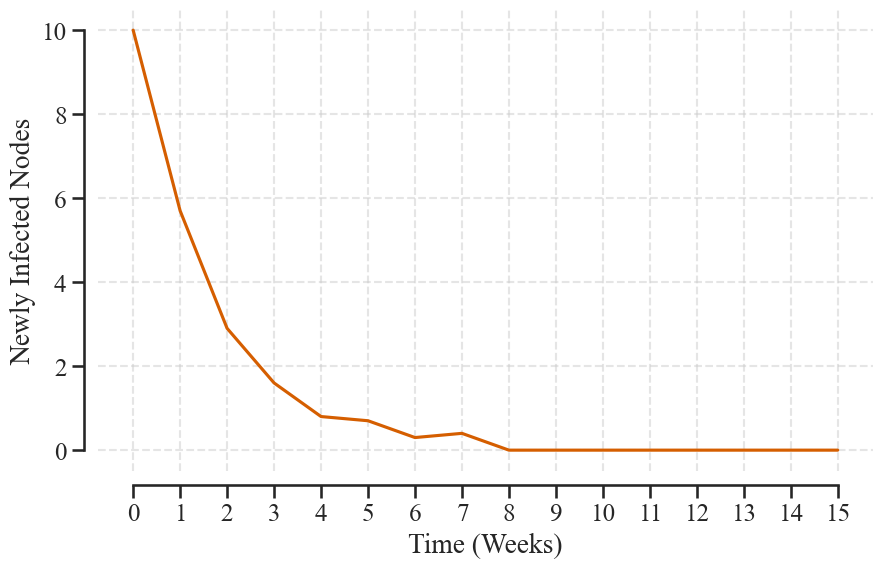

In [232]:
ni_plot(ni, file="11NI.pdf")

Figure saved to 11SRI.pdf


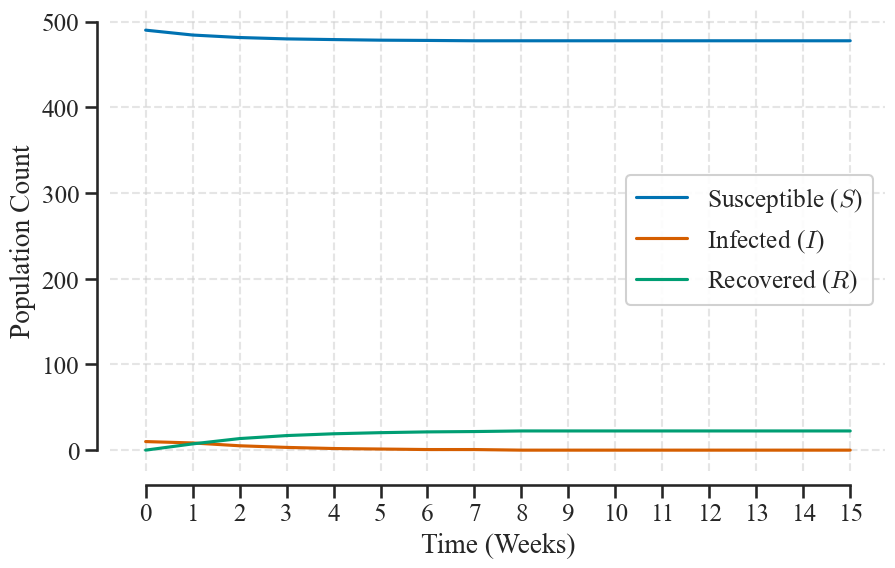

In [233]:
sir_plot(s, i, r, file="11SRI.pdf")

### b) Generate a random graph
In this part you will generate a random graph according to the preferential attachment model. The goal is to have a randomly generated graph with average degree close to $k$. The idea is the following: at time $t = 1$ we start with an initial graph $\mathcal{G}_1$  , that is complete with $k + 1$ nodes. Then at every time $t ≥ 2$, create a new graph $\mathcal{G}_t = (\mathcal{V}_t , \mathcal{E}_t )$ by adding a new node to $\mathcal{G}_t−1$ and connect it to some of the existing nodes $\mathcal{V}_{t−1}$ of $\mathcal{G}_{t−1}$ chosen according to some stochastic rule.

The rule by which the new node add links to the nodes of $\mathcal{G}_{t−1}$ is **preferential attachment**.

Average degree:  4.0
Drawing the generated preferential attachment random graph...


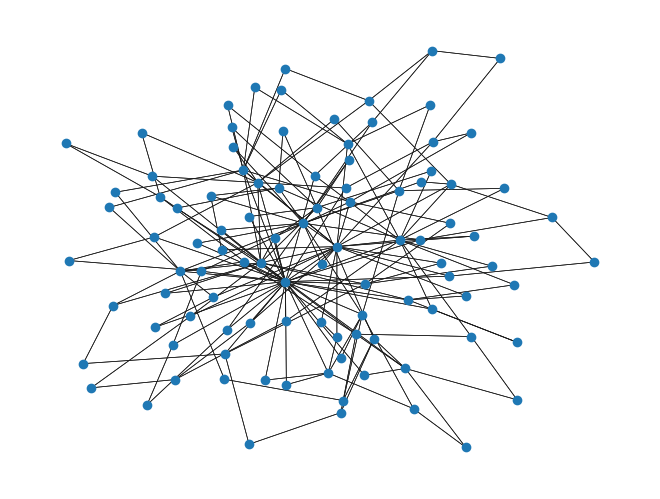

In [234]:
nodes = 100
k_degree = 4
graph = generator_preferential_attachment(nodes, k_degree)
W = nx.adjacency_matrix(graph)
W = W.toarray()
w = np.sum(W, axis=1)
print("Average degree: ", np.mean(w))

print("Drawing the generated preferential attachment random graph...")
nx.draw(graph, node_size=30, width=0.5, arrows = False)
plt.savefig("preferential_attachment_graph.pdf", format='pdf',dpi=300)
plt.show()

## ex. 1.2 - Simulate a pandemic without vaccination


In [235]:
s, i, r, ni = epidemic(n_simulations=100,
                       type_graph="preferential_attachment",
                       k_neighbors= 6,
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       n_weeks=15,
                       n_infected_init=10)

In [236]:
ni12 = ni # to compare with vaccination scenario

Figure saved to 12NI.pdf


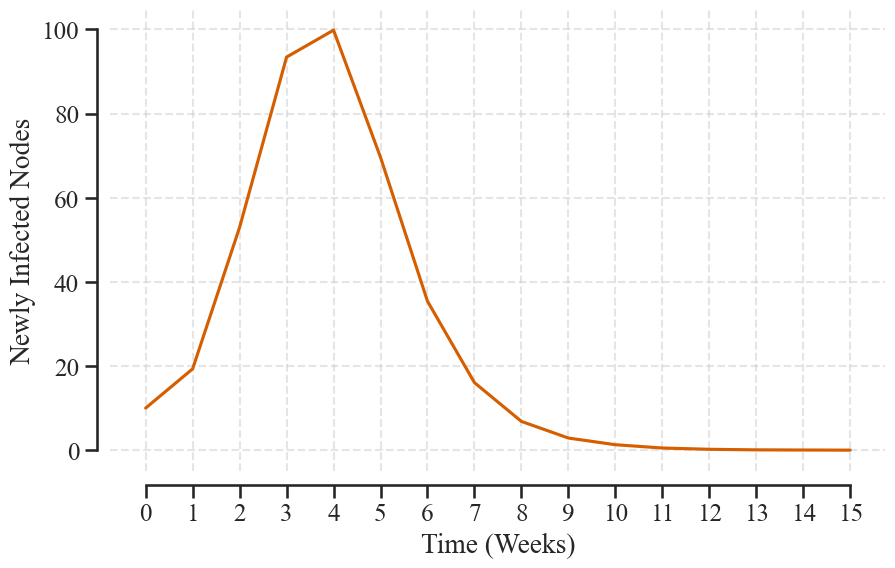

In [237]:
ni_plot(ni, file="12NI.pdf")

Figure saved to 12SRI.pdf


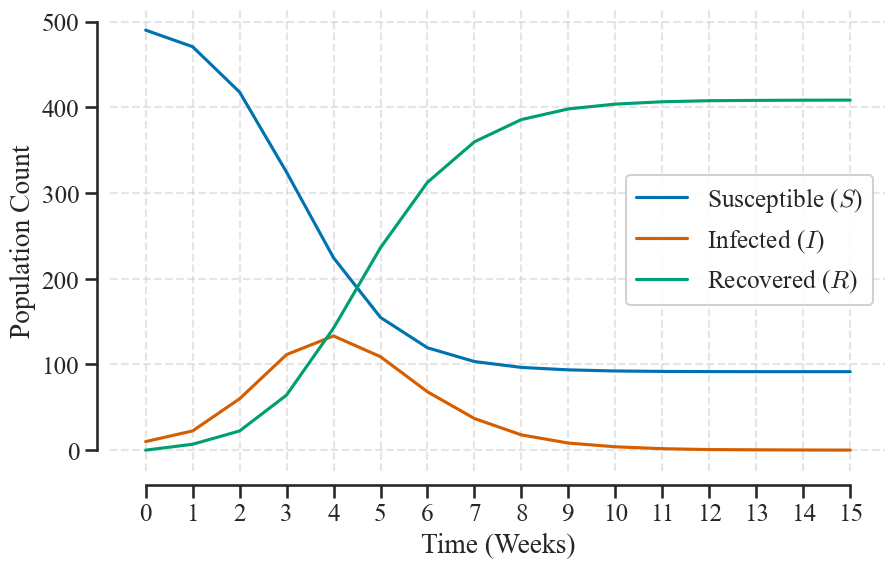

In [238]:
sir_plot(s, i, r, file="12SRI.pdf")

## ex. 1.3 - Simulate a pandemic with vaccination

In [239]:
vaccination_vector = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

s, i, r, ni, v, nv = epidemic(n_simulations=100,
                              type_graph="preferential_attachment",
                              k_neighbors= 6,
                              n_nodes=500,
                              beta=0.3,
                              rho=0.7,
                              n_weeks=15,
                              n_infected_init=10,
                              vacc=vaccination_vector)

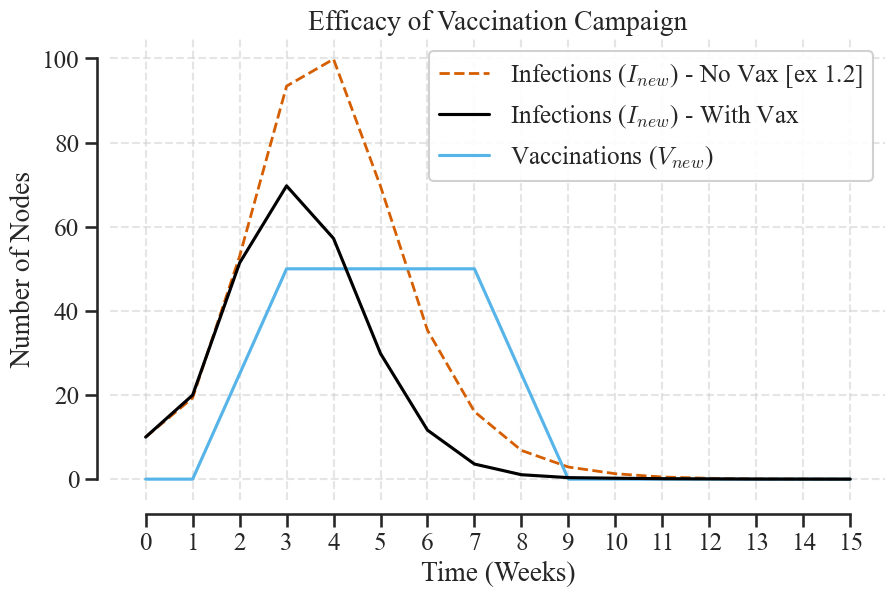

In [240]:
fig, ax = plt.subplots(figsize=(10, 6))

ticks = np.arange(0, len(ni12), dtype=int)

# Plot 1: Without Vaccination (Dashed Red)
ax.plot(ticks, ni12, label=r"Infections ($I_{new}$) - No Vax [ex 1.2]", 
        color="#D55E00", linestyle="--", markersize=6, linewidth=2)

# Plot 2: With Vaccination (Solid Black)
ax.plot(ticks, ni, label=r"Infections ($I_{new}$) - With Vax", 
        color="black", linestyle="-", markeredgecolor='white', markeredgewidth=1.5, markersize=7, zorder=10)

# Plot 3: Newly Vaccinated (Solid Blue)
ax.plot(ticks, nv, label=r"Vaccinations ($V_{new}$)", 
        color="#56B4E9", linestyle="-", markeredgecolor='white', markeredgewidth=1.5, markersize=7)

# Labels
ax.set_xticks(ticks)
ax.set_xlabel('Time (Weeks)')
ax.set_ylabel('Number of Nodes')
ax.set_title(r'Efficacy of Vaccination Campaign')

# Style
sns.despine(trim=True, offset=10)
ax.legend(loc='upper right')

plt.savefig("13NI.pdf", format='pdf')
plt.show()

Figure saved to 13SRI.pdf


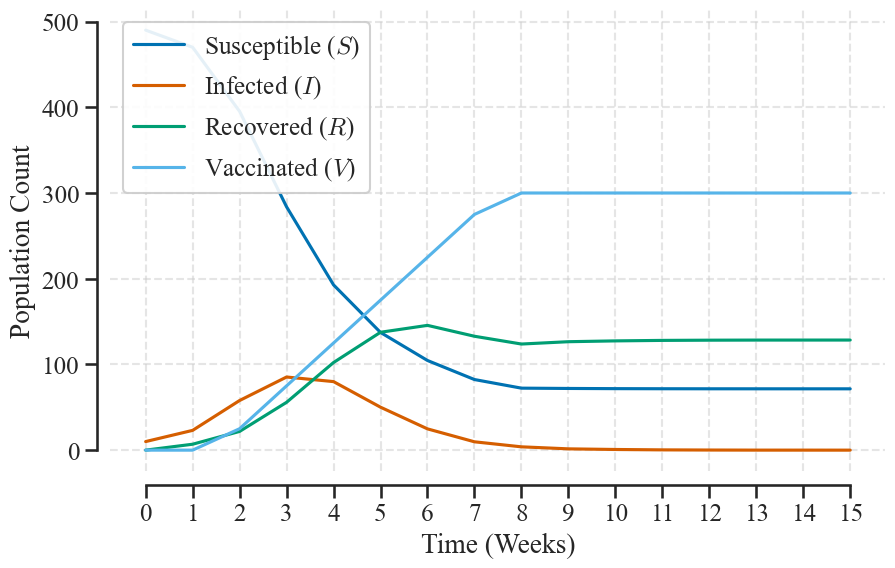

In [241]:
sir_plot(s, i, r, v, file="13SRI.pdf")

## ex. 1.4 - The **H1N1 pandemic** in $\text{Sweden 2009}$

ALERT! It takes ≈ 9 minutes to run this algorithm

In [242]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infection_vector  =  [1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0, 0]
RMSE, new_k, new_beta, new_rho = search_parameters(vaccination_vector, infection_vector, 
                                                   type_graph = "preferential_attachment", 
                                                   k0 = 8, dk = 1, 
                                                   beta0 = 0.2, dbeta = 0.025, 
                                                   rho0 = 0.6, drho = 0.025)


Starting step 0 ...
Best RMSE 3.998
Previous parameter: k=8.000 beta=0.200 rho=0.600
Actual parameters : k=8.000 beta=0.200 rho=0.625
New Best result found ..........................

Starting step 1 ...
Best RMSE 3.915
Previous parameter: k=8.000 beta=0.200 rho=0.625
Actual parameters : k=8.000 beta=0.175 rho=0.650
New Best result found ..........................

Starting step 2 ...
Best RMSE 2.991
Previous parameter: k=8.000 beta=0.175 rho=0.650
Actual parameters : k=8.000 beta=0.175 rho=0.625
New Best result found ..........................

Starting step 3 ...
Best RMSE 3.695
Previous parameter: k=8.000 beta=0.175 rho=0.625
Actual parameters : k=8.000 beta=0.200 rho=0.600

Starting step 4 ...
Best RMSE 3.653
Previous parameter: k=8.000 beta=0.200 rho=0.600
Actual parameters : k=9.000 beta=0.175 rho=0.600

Starting step 5 ...
Best RMSE 3.399
Previous parameter: k=9.000 beta=0.175 rho=0.600
Actual parameters : k=8.000 beta=0.175 rho=0.625

Starting step 6 ...
Best RMSE 2.992
Previo

In [243]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
print("Best result achieve: RMSE:{:.2f}, k:{:.2f}, Beta:{:.2f}, rho:{:.2f}".format( RMSE, new_k, new_beta, new_rho))

s, i, r, ni, v, nv = epidemic(n_simulations = 100,
                              type_graph="preferential_attachment",
                              k_neighbors = int(new_k),
                              n_nodes=934,
                              beta = new_beta,
                              rho = new_rho,
                              n_weeks=15,
                              n_infected_init=1,
                              vacc=vaccination_vector)
#best RMSE:2.64, k:9.00, Beta:0.175, rho:0.60

Best result achieve: RMSE:2.23, k:11.00, Beta:0.15, rho:0.62


Figure saved to 14NI.pdf


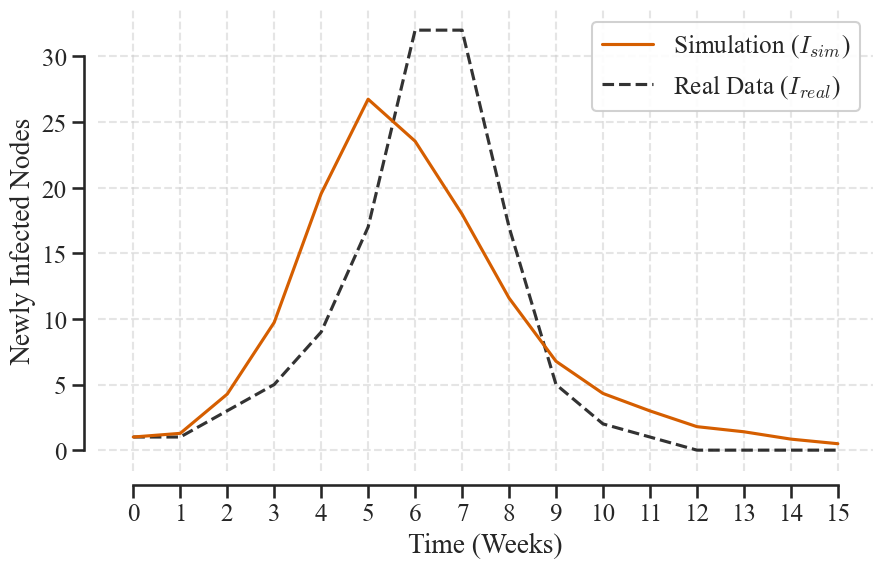

In [244]:
infection_vector = [1, 1,  3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0,  0]
ni_comparison_plot(ni, infection_vector, file="14NI.pdf")

Figure saved to 14SRI.pdf


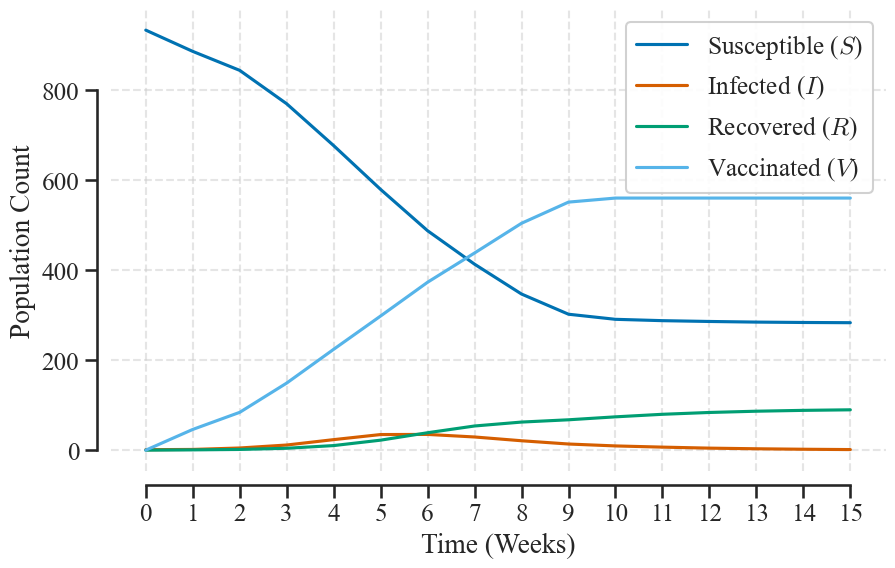

In [245]:
sir_plot(s, i, r, v, file="14SRI.pdf")

In [246]:
s,i,r,v

(array([933.  , 885.8 , 843.65, 769.42, 676.49, 579.15, 487.39, 413.09,
        346.76, 301.94, 290.63, 287.64, 285.85, 284.45, 283.61, 283.12]),
 array([ 1.  ,  1.58,  4.78, 11.39, 23.36, 34.66, 34.93, 29.24, 20.86,
        13.62,  9.37,  6.71,  4.45,  3.05,  2.  ,  1.27]),
 array([ 0.  ,  0.62,  1.57,  4.19, 10.15, 22.19, 38.68, 53.67, 62.38,
        67.44, 74.  , 79.65, 83.7 , 86.5 , 88.39, 89.61]),
 array([  0.,  46.,  84., 149., 224., 298., 373., 438., 504., 551., 560.,
        560., 560., 560., 560., 560.]))

## ex. 1.5.1 -**H1N1 pandemic $\text{CHALLENGE}$**

In [247]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infection_vector = [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0, 0]
RMSE, new_k, new_beta, new_rho, new_prob = search_parameters(vaccination_vector, infection_vector, 
                                                   type_graph = "newman_watts_strogatz", 
                                                   k0 = 9, dk = 1, 
                                                   beta0 = 0.25, dbeta = 0.025, 
                                                   rho0 = 0.95, drho = 0.025,
                                                   p0 = 0.5, dp = 0.025)


Starting step 0 ...
Best RMSE 4.662
Previous parameter: k=9.000 beta=0.250 rho=0.950 prob=0.525
Actual parameters : k=8.000 beta=0.250 rho=0.925 prob=0.500
New Best result found ..........................

Starting step 1 ...
Best RMSE 4.421
Previous parameter: k=8.000 beta=0.250 rho=0.925 prob=0.525
Actual parameters : k=9.000 beta=0.250 rho=0.950 prob=0.475
New Best result found ..........................

Starting step 2 ...
Best RMSE 4.493
Previous parameter: k=9.000 beta=0.250 rho=0.950 prob=0.500
Actual parameters : k=8.000 beta=0.250 rho=0.975 prob=0.450

Starting step 3 ...
Best RMSE 4.156
Previous parameter: k=8.000 beta=0.250 rho=0.975 prob=0.475
Actual parameters : k=8.000 beta=0.250 rho=0.950 prob=0.475
New Best result found ..........................

Starting step 4 ...
Best RMSE 4.163
Previous parameter: k=8.000 beta=0.250 rho=0.950 prob=0.500
Actual parameters : k=8.000 beta=0.225 rho=0.975 prob=0.500

Starting step 5 ...
Best RMSE 4.640
Previous parameter: k=8.000 bet

In [248]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
print("Best result achieve: RMSE:{:.3f}, k:{:.3f}, Beta:{:.3f}, rho:{:.3f}, p:{:.3f}".format( RMSE, new_k, new_beta, new_rho, new_prob))

s, i, r, ni, v, nv = epidemic(n_simulations = 100,
                              type_graph = "newman_watts_strogatz",
                              k_neighbors = int(new_k),
                              n_nodes = 934,
                              beta = new_beta,
                              rho = new_rho,
                              n_weeks = 15,
                              n_infected_init=1,
                              vacc = vaccination_vector,
                              prob = new_prob)
# Best result achieve: RMSE:3.733, k:9.000, Beta:0.250, rho:1.000, p:0.500

Best result achieve: RMSE:3.264, k:8.000, Beta:0.250, rho:1.000, p:0.575


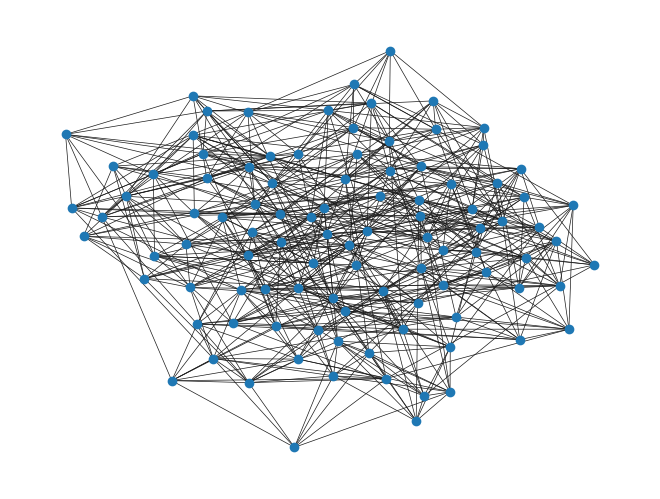

In [249]:
graph = generator_newman_watts_strogatz(100, int(new_k))    
nx.draw(graph, node_size=30, width=0.5)

plt.savefig("newman_watts_strogatz.pdf", format='pdf',dpi=300)
plt.show()

Figure saved to 15SRI.pdf


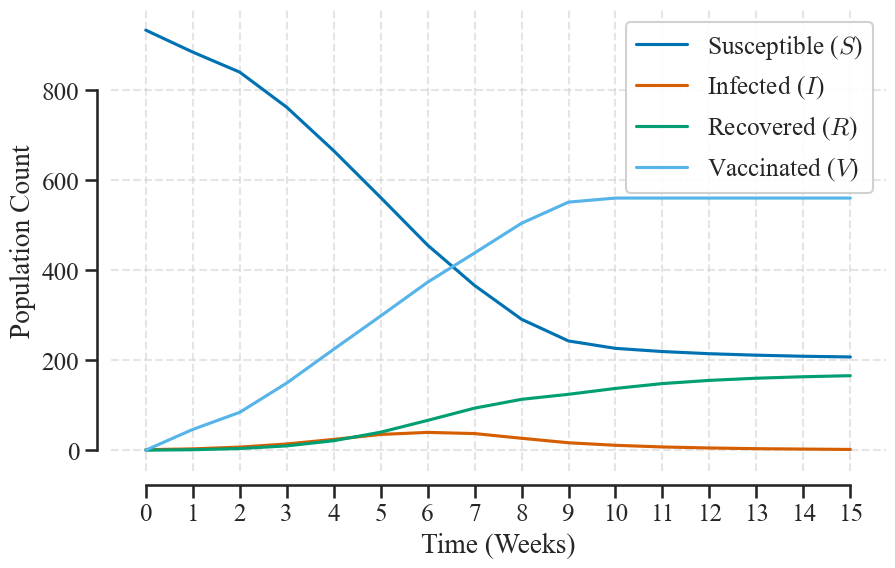

In [250]:
sir_plot(s, i, r, v, file='15SRI.pdf')

Figure saved to 15NI.pdf


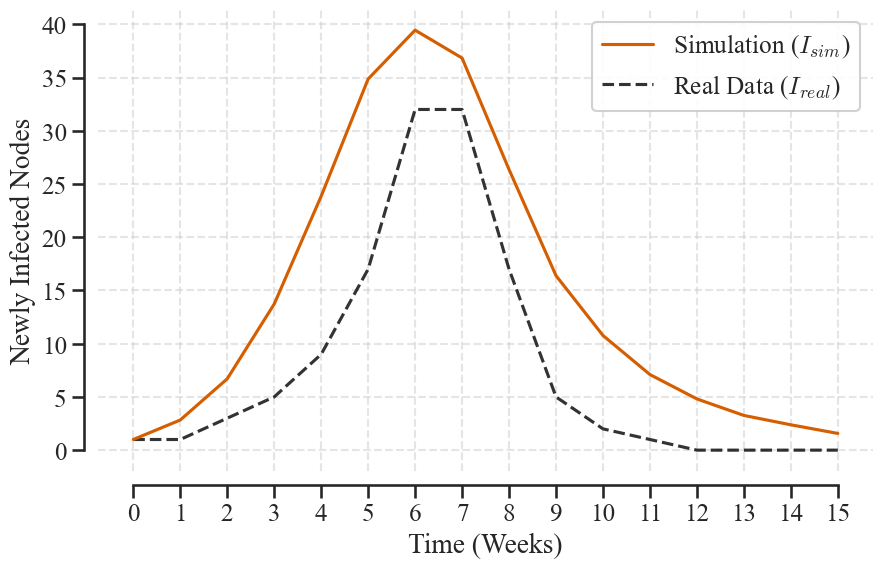

In [251]:
infection_vector = [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0, 0, 0]
ni_comparison_plot(ni, infection_vector, file="15NI.pdf") 

In [253]:
s,i,r,v

(array([933.  , 884.24, 839.73, 761.83, 665.22, 561.29, 455.44, 365.87,
        290.75, 242.55, 226.12, 219.02, 214.21, 210.95, 208.57, 207.  ]),
 array([ 1.  ,  2.83,  6.7 , 13.72, 23.85, 34.86, 39.45, 36.83, 26.36,
        16.39, 10.77,  7.1 ,  4.81,  3.26,  2.38,  1.57]),
 array([  0.  ,   0.93,   3.57,   9.45,  20.93,  39.85,  66.11,  93.3 ,
        112.89, 124.06, 137.11, 147.88, 154.98, 159.79, 163.05, 165.43]),
 array([  0.,  46.,  84., 149., 224., 298., 373., 438., 504., 551., 560.,
        560., 560., 560., 560., 560.]))